In [1]:
%config ZMQInteractiveShell.ast_node_interactivity = "all"
%pprint

Pretty printing has been turned OFF


In [2]:
import os
os.environ["CUDA_LAUNCH_BLOKING"] = "1"

## relu实现

$Relu = max(0, x)$
- 过往的神经网络都常用sigmoid和tanh(x)
- 但是sigmoid有诸如存在饱和区域，计算量大，非零中心化缺点
- relu不存在饱和区域，导数简单，计算快（随着网络层数的增加，sigmoid计算缓慢），单侧抑制
    - 但是左侧区域会出现“死亡”
- 其导数为I(x>0)

In [2]:
import sys
sys.path.append("../d2l_func/")
import torch
import matplotlib.pyplot as plt
from draw import set_fig_display

%matplotlib inline
plt.rcParams["axes.spines.top"] = False
plt.rcParams["axes.spines.right"] = False
plt.rcParams["figure.figsize"] = [14, 7]
plt.rcParams["font.size"] = 14
plt.rcParams["axes.facecolor"] = "WhiteSmoke"

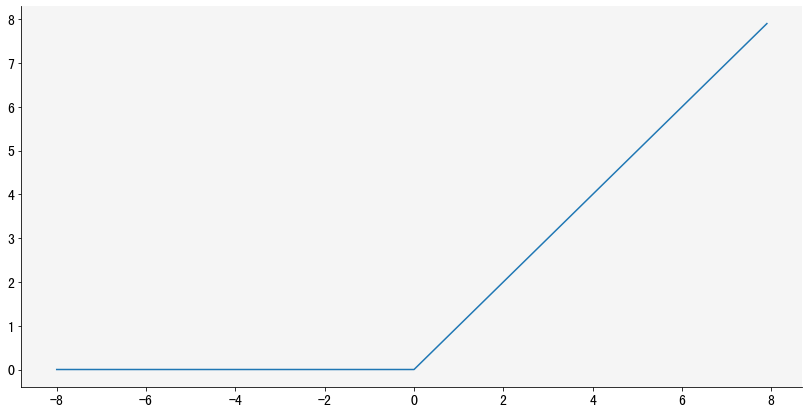

In [3]:
x = torch.arange(-8, 8, 0.1, requires_grad=True)
y = x.relu()
# 有梯度的时候画不了图
plt.plot(x.detach().numpy(), y.detach().numpy())

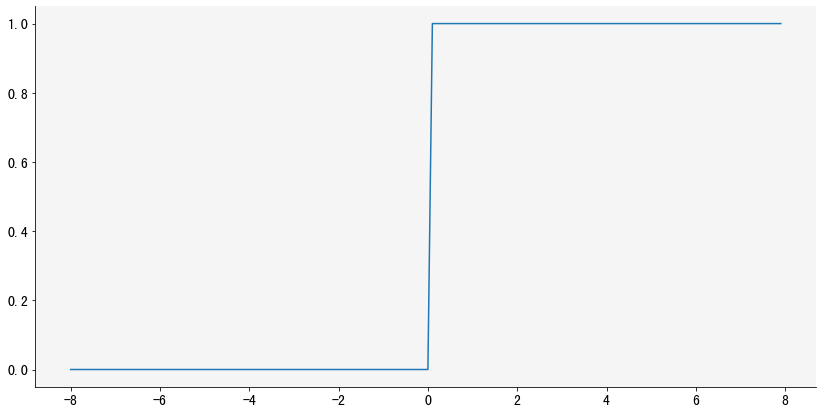

In [4]:
# 梯度回传(只能是一个数字)
y.sum().backward()
plt.plot(x.detach().numpy(), x.grad.detach().numpy())

## sigmoid实现

$sigmoid(x) = \frac{1}{1+exp(-x)}$

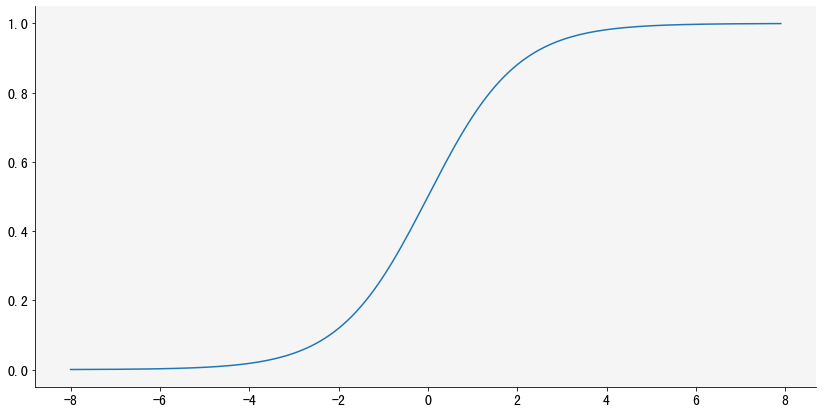

In [5]:
y = x.sigmoid()
plt.plot(x.detach().numpy(), y.detach().numpy())

导数为$(1- sigmoid(x))sigmoid(x)$

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

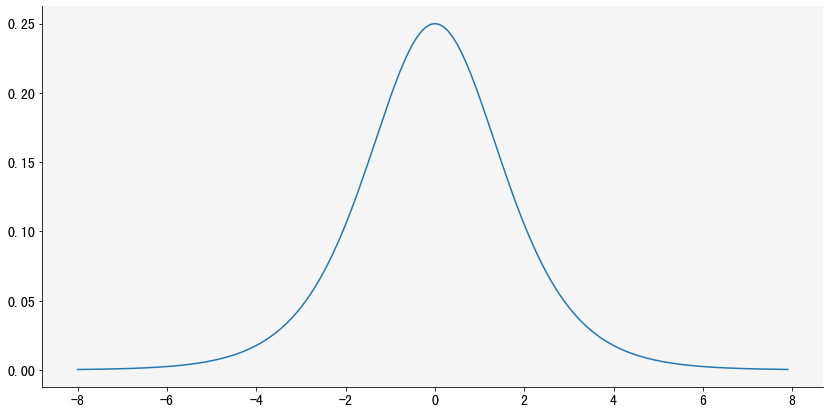

In [6]:
# 之前使用过，要梯度清零
x.grad.data.zero_()
y.sum().backward()
plt.plot(x.detach().numpy(), x.grad.detach().numpy())

sigmoid梯度的取值范围为[0, 0.25]

## tanh

$tanh(x) = \frac{exp(x) - exp(-x)}{exp(x) + exp(-x)}$

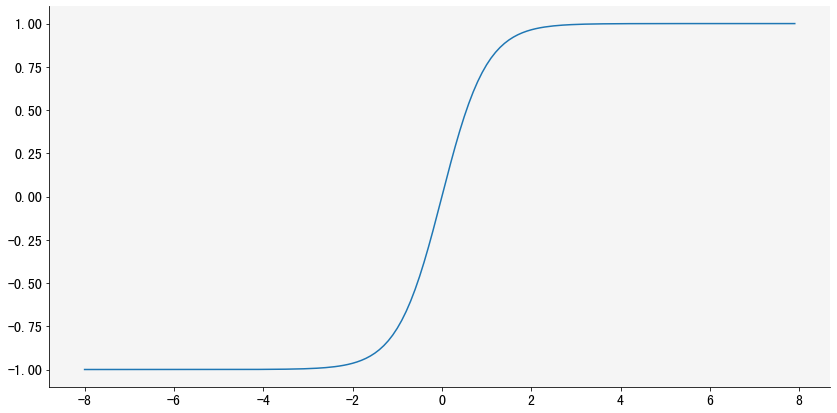

In [7]:
# y = (torch.exp(x) - torch.exp(-x)) / (torch.exp(x) + torch.exp(-x))
y = x.tanh()
plt.plot(x.detach().numpy(), y.detach().numpy())

导数为$1- tanh^2(x)$

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

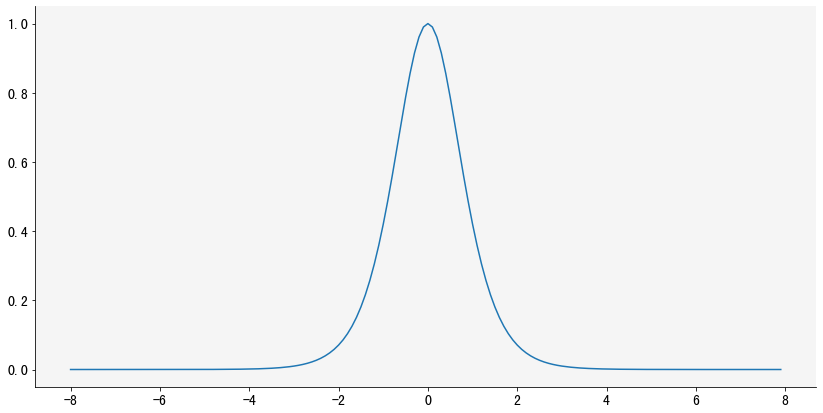

In [8]:
# 之前使用过，要梯度清零
x.grad.data.zero_()
y.sum().backward()
plt.plot(x.detach().numpy(), x.grad.detach().numpy())

$tanh梯度的取值范围为[0, 1]$

## MLP从零实现

In [3]:
import sys
import torch
import torch.utils.data as Data
sys.path.append("../d2l_func/")
from model_train import train_pytorch, train_experiment
from data_prepare import download_data_fashion_mnist, load_data_fashion_mnist

In [10]:
class MLP(object):
    def __init__(self, input_num, hidden_num, output_num):
        self.w1 = torch.normal(0, 0.01, size=(input_num, hidden_num), requires_grad=True)
        self.b1 = torch.zeros(hidden_num, requires_grad=True)
        self.w2 = torch.normal(0, 0.01, size=(hidden_num, output_num), requires_grad=True)
        self.b2 = torch.zeros(output_num, requires_grad=True)
        self.input_num = input_num
        self.hidden_num = hidden_num
        self.output_num = output_num
        
    @staticmethod
    def linreg(X, w, b):
        return torch.mm(X, w) + b
    
    @staticmethod
    def relu(y_pred):
        # pytorch中没有maximum
        return torch.max(y_pred, torch.tensor([0.]))
    
    @staticmethod
    def softmax(y_pred):
        return torch.exp(y_pred)/(torch.exp(y_pred).sum(axis=1, keepdims=True))
    
    def entropy_loss(self, y_pred, y):
        y_pred = torch.gather(y_pred, 1, y.unsqueeze(1))
        return -(y_pred.clamp(1e-12).log()).sum() / len(y)
    
    def predict_prob(self, X):
        # reshape X
        X = X.view(-1, self.input_num)
        a1 = self.relu(self.linreg(X, self.w1, self.b1))
        y_pred = self.softmax(self.linreg(a1, self.w2, self.b2))
        return y_pred
        
    def predict(self, X):
        y_pred = self.predict_prob(X)
        y_pred = torch.argmax(y_pred, dim=1)
        return y_pred
    
    def score(self, X, y):
        y_pred = self.predict(X)
        acc = (y_pred == y).sum().item() / len(y)
        return acc

In [11]:
# define model
model = MLP(input_num=28*28, hidden_num=300, output_num=10)
# load data
mnist_train, mnist_test = download_data_fashion_mnist()

params = {
    "model": model.predict_prob,
    "loss": model.entropy_loss,
    "epoch_num": 50,
    "data_num": len(mnist_train),
    "batch_size": 512,
    "lr": 0.1,
    "weight_decay": 0,
    "params": [model.w1, model.b1, model.w2, model.b2],
    "test_iter": Data.DataLoader(mnist_test, batch_size=len(mnist_test)),
    "evaluate": model.score,
}


train_iter, test_iter = load_data_fashion_mnist(batch_size=params["batch_size"], num_workers=8)
params["train_iter"] = train_iter
train_experiment(**params)

Epoch [1/50]
60000/60000 [>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] - train_loss: 1.3067, train_score: 0.576, test_loss: 1.3028, test_score: 0.573

Epoch [2/50]
60000/60000 [>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] - train_loss: 0.7338, train_score: 0.728, test_loss: 0.7507, test_score: 0.720

Epoch [3/50]
60000/60000 [>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] - train_loss: 0.6156, train_score: 0.785, test_loss: 0.6367, test_score: 0.773

Epoch [4/50]
60000/60000 [>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] - train_loss: 0.5630, train_score: 0.805, test_loss: 0.5857, test_score: 0.793

Epoch [5/50]
60000/60000 [>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] - train_loss: 0.5251, train_score: 0.817, test_loss: 0.5507, test_score: 0.805

Epoch [6/50]
60000/60000 [>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] - train_loss: 0.5016, train_score: 0.824, test_loss: 0.5295, test_score: 0.812

Epoch [7/50]
60000/60000 [>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] - train_loss: 0.4839, train_score: 0.831, test_loss: 0.5126, test_score: 0.819

Epoch [8/50]
60000/60000 [>>>>>>>>

## MLP简洁实现

In [4]:
import torch
import torch.nn as nn
import torch.nn.init as init
import sys
sys.path.append("../d2l_func/")
from model_train import train_pytorch

In [5]:
class FlattenLayer(nn.Module):
    def __init__(self):
        super(FlattenLayer, self).__init__()
        
    def forward(self, X):
        X = X.view(X.shape[0], -1)
        return X
        
class MLPModel(nn.Module):
    def __init__(self):
        super(MLPModel, self).__init__()
        self.layer = nn.Sequential(
            FlattenLayer(),
            nn.Linear(784, 300),
            nn.ReLU(),
            nn.Linear(300, 10),
        )
        
    def forward(self, X):
        y = self.layer(X)
        return y
    
    def score(self, X, y):
        y_pred = self.forward(X)
        acc = (y_pred.argmax(dim=1) == y).sum().item() / len(y)
        return acc

In [19]:
# define model
model = MLPModel()
# init weight and bias
for net in model.layer:
    if isinstance(net, nn.Linear):
        _ = init.normal_(net.weight, 0, 0.01)
        _ = init.constant_(net.bias, 0)

# 用gpu跑
model = model.cuda()
# loss
loss = nn.CrossEntropyLoss()
# load data
mnist_train, mnist_test = download_data_fashion_mnist()
# optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=0.1, momentum=0.9)

params = {
    "model": model,
    "loss": loss,
    "epoch_num": 50,
    "data_num": len(mnist_train),
    "batch_size": 512,
    "optimizer": optimizer,
    "test_iter": Data.DataLoader(mnist_test, batch_size=len(mnist_test)),
    "evaluate": model.score,
    "gpu": True,
}

train_iter, test_iter = load_data_fashion_mnist(batch_size=params["batch_size"], num_workers=8)
params["train_iter"] = train_iter

# training
train_pytorch(**params)

Epoch [1/50]
60000/60000 [>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] - train_loss: 0.8012, train_score: 0.711, test_loss: 0.8055, test_score: 0.708

Epoch [2/50]
60000/60000 [>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] - train_loss: 0.4259, train_score: 0.846, test_loss: 0.4554, test_score: 0.837

Epoch [3/50]
60000/60000 [>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] - train_loss: 0.3902, train_score: 0.859, test_loss: 0.4282, test_score: 0.845

Epoch [4/50]
60000/60000 [>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] - train_loss: 0.3644, train_score: 0.868, test_loss: 0.4067, test_score: 0.853

Epoch [5/50]
60000/60000 [>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] - train_loss: 0.3457, train_score: 0.874, test_loss: 0.3905, test_score: 0.858

Epoch [6/50]
60000/60000 [>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] - train_loss: 0.3286, train_score: 0.879, test_loss: 0.3812, test_score: 0.862

Epoch [7/50]
60000/60000 [>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] - train_loss: 0.3158, train_score: 0.885, test_loss: 0.3701, test_score: 0.866

Epoch [8/50]
60000/60000 [>>>>>>>>

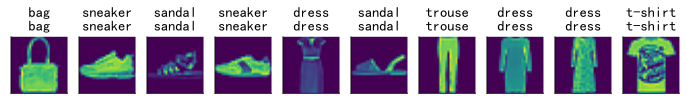

In [20]:
# testing
from draw import get_fashion_mnist_label, show_fashion_mnist

x, y = iter(test_iter).next()
x = x.cuda()
y = y.cuda()
true_label = get_fashion_mnist_label(y)

pred_label = get_fashion_mnist_label(model(x).to("cpu").argmax(dim=1))
label = [true + "\n" + pred for true, pred in zip(true_label, pred_label)]
x = x.to("cpu")
y = y.to("cpu")
show_fashion_mnist(x[:10], label[:10])